In [ ]:
#hide
%load_ext autoreload

In [ ]:
from nbdev import *

In [ ]:
#default_exp annotate

# Annotate

> Tools to support creating and process annotation for samples of Newspaper Navigator data using Label Studio.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from tqdm.notebook import trange, tqdm
import pandas as pd
from pandas import json_normalize
import simplejson as json
import requests
import re
from glob import glob
from pathlib import Path

In [ ]:
import nnanno
from typing import Union 

# Setup annotation task
The bulk of annotation work is outsourced to label studio, label studio is a flexible annotations system which supports annotations for a range of types of data including images and text. This module does a few steps to help process annotations produced through label studio. This module is largely some suggestions on how you can get label studio setup with data from Newspaper Navigator. 

First we'll create a small sample of images we want to annotate. If you have already done this step you can skip this. 

In [ ]:
from nnanno.sample import *
from nnanno.core import *

In [ ]:
sampler = nnSampler()

In [ ]:
df = sampler.create_sample(50,'photos', start_year=1910, end_year=1920, year_sample=False)

As a reminder of what this data looks like

In [ ]:
df.head(1)

filepath  \
0  oru_hufnagel_ver02/data/97071090/00200298147/1910061501/0239/011_0_98.jpg   

     pub_date  page_seq_num edition_seq_num               batch      lccn  \
0  1910-06-15           239               1  oru_hufnagel_ver02  97071090   

                                                                                box  \
0  [0.2934526012789819, 0.19737717519581938, 0.680090069514449, 0.5958451531750109]   

     score  \
0  0.98956   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ocr  \
0  [Senator, William, LSE, O'NEILL, The, Investigation, of, tlio, charges, of, bnbet.x, iigiiliiNt, 'iiutor, William, Lorluicr, ha-, not, bt-on, ioikIuiKhI, and, will, not, bo, until, State, Attorney, Wayman.lias, time, to, consider, Mnn, new, points, that, have, been, presented, to, him., Sen., ntur, I.orlmer, Is, due, to, make, his, hpcix-Ii, In, the, scmitc, .uww', i''m, ;In, liarges, within, a, fuw, davn, Lorimer, of, Illinois, And, Some, of, the, Witnesses., BROWN, ii', CHARLES, ?., WHITE]   

  place_of_publication geographic_coverage  \
0              Oregon.                  []   

                                                                name  \
0  Medford mail tribune. (Medford, Or.) 1909-1989. [online resource]   

  publisher  \
0       NaN   

                                                                                                                  url  \
0  https://news-navigator.labs.loc.gov/data/oru_hufnagel_ver02/data/97071090/00200298147/1910061501/0239/011_0_98.jpg   

                                                                                                           page_url  
0  https://chroniclingamerica.loc.gov/data/batches/oru_hufnagel_ver02/data/97071090/00200298147/1910061501/0239.jp2

There are a few ways in which we can use label studio to annotate. We could download images from our sample using `sample.download_sample`. If we have a large sample though we might want to do some annotating before we download all of these  images locally. 

label studio supports annotating form a url. We can use this in combination with IIIF to annotate images without having to download them all first. Since IIIF is such a flexible interface for getting images this also gives us flexibility in annotating at a lower resolution/size before downloading higher res images. 

## Create label studio annotation tasks

label studio supports a load of different ways of setting up 'tasks'. In this context a 'task' is an image to be annotated. One way of setting up a task is to import a `JSON` file which includes tasks. To do this we take an existing sample DataFrame and add an additional column `image` which contains a IIIF URL. 

In [ ]:
#export
def create_label_studio_json(sample: Union[pd.DataFrame,nnSampler], fname:Union[str,Path], original: bool = True,  pct: Optional[int] = None,  size: Optional[tuple] = None, preserve_asp_ratio: bool = True):
    """create a json file which can be used to upload tasks to label studio"""
    if type(sample) == nnanno.sample.nnSampler:
        try:
            sample = sample.sample.copy()
        except AttributeError as e:
            print(f"{sample} doesn't have a sample associated with it")
    else:
        sample = sample.copy()
    sample["image"] = sample.apply(
                lambda x: iiif_df_apply(
                    x,
                     original=original,
                     pct=pct,
                     size=size,
                     preserve_asp_ratio=preserve_asp_ratio,
                ),
        
                axis=1,
            )
    label_studio_json = sample.apply(lambda x:x.to_dict(), axis=1).to_list()
    with open(fname,'w') as f:
        json.dump(label_studio_json,f, ignore_nan=True)
        

We can pass in either a dataframe or `nnSampler` to `create_label_studio_json`. This will setup a `JSON` file which can be used to create tasks in labels studio

In [ ]:
create_label_studio_json(df,'tasks.json', size=(500,500))

This creates a `JSON` file we can use to load tasks into label studio. 


### Importing tasks into label studio
To avoid this documentation becoming out of date I haven't included screenshots etc. However, you can currently (January 2021) create tasks in label studio via the GUI or by passing in tasks through the CLI. For example to load the tasks and create a template for annotating classifications

```bash
label-studio init project_name --template=image_classification --input-path=tasks.json
```


You can then start label-studio and complete the rest of the setup via the GUI. 


```bash
label-studio start ./project_name
```

## Setting up labeling

For a proper introduction to configuring your labels consult the label studio [documentation](https://labelstud.io/guide/). One way in which you can setup labels is to use a template as shown above for setting up image classification. There are other [templates](https://labelstud.io/templates/) for other tasks. These templates consist of `XML` templates that are used to define your labels. These templates allow you to both define how you want to label your images and to share these definitions with others. For example

```xml
<View>
  <Choices name="choice" toName="image" showInLine="true" choice="multiple">
        <Choice value="human"/>
    	<Choice value="animal"/>
    	<Choice value="human-structure"/>
     	<Choice value="landscape"/>
  </Choices>
<Image name="image" value="$image"/>
</View>
```

There are a bunch of other options you can change in label studio, and features such as adding a machine learning backend to support annotations. These are discussed in more detail in the label studio documentation. 

### Notes on labeling via IIIF 

- missing images
- set a comfortable size for viewing 
- you can download at a different size
- bounding box,pixels etc want to make sure images are consistent 

### Exporting and loading annotations from label studio 

In [ ]:
#export 
def load_annotations_csv(csv: Union[str, Path], kind='classification'):
    if kind == 'classification':
        return pd.read_csv(csv, converters={'box':eval})
    if kind == 'label':
        df = pd.read_csv(csv, converters={'box':eval, 'choice':eval})
        df['label'] = df.apply(lambda x: x.choice['choices'], axis=1)
        return df

In [ ]:
annotation_df = load_annotations_csv('test_iiif_anno/label_studio_export.csv')
annotation_df.columns

Index(['batch', 'box', 'edition_seq_num', 'filepath', 'geographic_coverage',
       'image', 'lccn', 'name', 'ocr', 'page_seq_num', 'page_url',
       'place_of_publication', 'pub_date', 'publisher', 'score', 'url', 'id',
       'choice'],
      dtype='object')

In [ ]:
# hide
assert 'choice' in annotation_df.columns

In [ ]:
# todo add column info

In [ ]:
annotation_df['choice'].value_counts()

Human       52
no_human    16
Name: choice, dtype: int64

In [ ]:
sampler.download_sample('test_iiif_anno/test_dl',df=annotation_df, json_name='test_dl')

In [ ]:
# test we have a very similar number of images downloaded and in our annotation dataframe 
# allow for some images to be missing
images = list(Path('test_iiif_anno/test_dl').rglob('*.jpg'))
test_close(len(images),len(annotation_df),eps=1)

### Loading with fastai

In [ ]:
#slow
from fastai.vision.all import *

In [ ]:
#slow
df = pd.read_json('test_iiif_anno/test_dl/test_dl.json')

In [ ]:
#slow
dls = ImageDataLoaders.from_df(df, path='test_iiif_anno/test_dl', 
                               fn_col='download_image_path', 
                               label_col='choice',
                               item_tfms=Resize(64), bs=4)

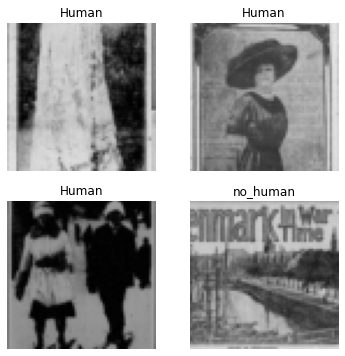

In [ ]:
#slow
dls.show_batch()

In [ ]:
#slow
[f.unlink() for f in Path('test_iiif_anno/test_dl').iterdir()]
Path('test_iiif_anno/test_dl').rmdir()

# Process completions directly 

\ # TODO add disclaimer 

In [ ]:
#export
def load_df(json_file):
    with open(json_file) as f:
        data = json.load(f)
        df = json_normalize(data,record_path=['completions'],meta=['data'])
       # df['result'] = df['result'].apply(lambda x: return_choice(x[0]) if len([x][0]) ==1 else x)
        df['result'] = df['result'].apply(lambda x: x[0]['value']['choices'] if len([x][0]) ==1 else x)
        return df

In [ ]:
#export
def load_completions(path):
    filenames = glob(f'{path}/completions/*.json')
    dataframes = [load_df(f) for f in filenames]
    return pd.concat(dataframes)

In [ ]:
#slow
df = load_completions('../ph/ads/ad_annotations/')
df.head(1)

created_at      id  lead_time           result  \
0  1602237290  457001      1.014  [illustrations]   

                                                data  
0  {'image': 'http://localhost:8081/data/upload/d...

In [ ]:
#slow
#df = load_completions('../ph/photos/multi_label/')
#df.head(1)

In [ ]:
#exporti
def _df_to_csv(df,out_fn):
    df[['data','result']].to_csv(out_fn,header=['file','label',],index=False)

In [ ]:
#exporti
def _df_to_json(df,out_fn):
    df[['data','value.choices']].to_json(out_fn)

In [ ]:
#exporti
def _df_to_pkl(df,out_fn):
    df.to_pickle(out_fn)

In [ ]:
#exporti
def get_og_filepath(x):
    """
    Transforms a filepaths from processed ImageStudio format back to the Orginal Newspaper Navigator filepath  format
    """
    b, m, e = re.split('(_data_)',x)
    m = m.replace('_','/')
    e = re.split('(\d{3}_\d{1}_\d{2}.jpg)',e)
    return b+m+e[0].replace('_','/') +e[1]

In [ ]:
#export
def anno_sample_merge(sample_df: pd.DataFrame, annotation_df: pd.DataFrame) -> pd.DataFrame:
    """anno_sample_merge merges a DataFrame containing a sample
    from Newspaper Navigator and a DataFrame containing annotations

    Parameters
    ----------
    sample_df : pd.DataFrame
        A Pandas DataFrame which holds a sample from Newspaper Navigator Generated by `sample.nnSample()`
    annotation_df : pd.DataFrame
        A pandas DataFrame containing annotations loaded via the `annotate.nnAnnotations` class


    Returns
    -------
    pd.DataFrame
        A new DataFrame which merges the two input DataFrames
    """
    sample_df, annotation_df = sample_df.copy(), annotation_df.copy()
    annotation_df['id'] = annotation_df['data'].map(lambda x:get_og_filepath(x))
    return sample_df.merge(annotation_df, left_on='filepath',right_on='id')

In [ ]:
sample_df= pd.read_csv('../ph/ads/sample.csv', index_col=0)

In [ ]:
#export

class nnAnnotations:
    def __init__(self, df):
        self.annotation_df = df
        self.labels = df['result'].unique()
        self.label_counts = df['result'].value_counts()

    def __repr__(self):
        return (f'{self.__class__.__name__}'
                f' #annotations:{len(self.annotation_df)}')

    @classmethod
    def from_completions(cls, path, kind, drop_dupes=True, sample_df=None):
        df = load_completions(path)
        df = df.reset_index(drop=True) # add index
        df['data']= df['data'].map(lambda x: x['image'])
        df['data'] = df['data'].map(lambda x: x.split('?')[0])
        df['data'] = df['data'].apply(lambda x: Path(x).name)
        if any(df['data'].str.contains('-')): # removes labelstudio hash from data loaded via web interface
            df['data'] = df['data'].str.split('-',expand=True)[1]
        if drop_dupes:
            df = df.drop_duplicates(subset='data',keep='last')
        if kind=='classification':
            empty_rows = df[df['result'].apply(lambda x:len(x)==0)].index
            df = df.drop(empty_rows)
            df['result'] = df['result'].map(lambda x: x[0])
        if kind=='label':
            df['result'] = df['result'].map(lambda x: "|".join(map(str,x)) if len(x) >=1 else x)
            df['result'] = df['result'].map(lambda x:"" if len(x)==0 else x)
        return cls(df)

    def merge_sample(self, sample_df):
        self.merged_df = anno_sample_merge(sample_df,self.annotation_df)

    def export_merged(self, out_fn):
        self.merged_df.to_csv(out_fn)

    def export_annotations(self, out_fn):
        df = self.annotation_df
        if not Path(out_fn).exists():
            Path(out_fn).touch()
        suffix = Path(out_fn).suffix
        if suffix == '.csv':
            _df_to_csv(df, out_fn)
        if suffix == '.json':
            _df_to_json(df,out_fn)
        if suffix == '.pkl':
            _df_to_pkl(df,out_fn)

In [ ]:
show_doc(nnAnnotations)

<h2 id="nnAnnotations" class="doc_header"><code>class</code> <code>nnAnnotations</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>nnAnnotations</code>(**`df`**)



In [ ]:
show_doc(nnAnnotations.from_completions)

<h4 id="nnAnnotations.from_completions" class="doc_header"><code>nnAnnotations.from_completions</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>nnAnnotations.from_completions</code>(**`path`**, **`kind`**, **`drop_dupes`**=*`True`*, **`sample_df`**=*`None`*)



In [ ]:
annotations = nnAnnotations.from_completions('../ph/ads/ad_annotations/', 'classification')

In [ ]:
annotations

nnAnnotations #annotations:549

In [ ]:
annotations.labels

array(['illustrations', 'text-only'], dtype=object)

In [ ]:
annotations.label_counts

text-only        376
illustrations    173
Name: result, dtype: int64

In [ ]:
show_doc(nnAnnotations.merge_sample)

<h4 id="nnAnnotations.merge_sample" class="doc_header"><code>nnAnnotations.merge_sample</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>nnAnnotations.merge_sample</code>(**`sample_df`**)



In [ ]:
annotations.merge_sample(sample_df)
annotations.merged_df.head(2)

filepath    pub_date  \
0  iahi_gastly_ver01/data/sn82015737/00279529091/...  1860-03-09   
1  ohi_cobweb_ver04/data/sn85026050/00280775848/1...  1860-08-17   

   page_seq_num  edition_seq_num              batch        lccn  \
0           447                1  iahi_gastly_ver01  sn82015737   
1           359                1   ohi_cobweb_ver04  sn85026050   

                                                 box     score  \
0  [Decimal('0.30762831315880534'), Decimal('0.04...  0.950152   
1  [Decimal('0.5799164973813336'), Decimal('0.730...  0.985859   

                                                 ocr  \
0  ['JTO', 'TMCE', 'An', 't%E', '3eott', 'County'...   
1  ['9', 'BI.', 'I', '.QJtf', 'A', 'never', 'fall...   

              place_of_publication          geographic_coverage  \
0                  Davenport, Iowa   ['Iowa--Scott--Davenport']   
1  Fremont, Sandusky County [Ohio]  ['Ohio--Sandusky--Fremont']   

                                name                  publisher  \
0  Daily Democrat and news. [volume]  Maguire, Richardson & Co.   
1          Fremont journal. [volume]                 I.W. Booth   

                                                 url  \
0  https://news-navigator.labs.loc.gov/data/iahi_...   
1  https://news-navigator.labs.loc.gov/data/ohi_c...   

                                            page_url  created_at  \
0  https://chroniclingamerica.loc.gov/data/batche...  1602237486   
1  https://chroniclingamerica.loc.gov/data/batche...  1602236992   

                                                  id  lead_time  \
0  iahi_gastly_ver01/data/sn82015737/00279529091/...      0.838   
1  ohi_cobweb_ver04/data/sn85026050/00280775848/1...      7.593   

          result                                               data  
0      text-only  iahi_gastly_ver01_data_sn82015737_00279529091_...  
1  illustrations  ohi_cobweb_ver04_data_sn85026050_00280775848_1...

In [ ]:
show_doc(nnAnnotations.export_merged)

<h4 id="nnAnnotations.export_merged" class="doc_header"><code>nnAnnotations.export_merged</code><a href="__main__.py#L36" class="source_link" style="float:right">[source]</a></h4>

> <code>nnAnnotations.export_merged</code>(**`out_fn`**)



In [ ]:
annotations.export_merged('testmerge.csv')

In [ ]:
show_doc(nnAnnotations.from_completions)

<h4 id="nnAnnotations.from_completions" class="doc_header"><code>nnAnnotations.from_completions</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>nnAnnotations.from_completions</code>(**`path`**, **`kind`**, **`drop_dupes`**=*`True`*, **`sample_df`**=*`None`*)



In [ ]:
#hide 
Path('testmerge.csv').unlink()

In [ ]:
annotations = nnAnnotations.from_completions('../ph/ads/ad_annotations/', 'classification')
annotations.annotation_df.head(2)

created_at      id  lead_time         result  \
0  1602237290  457001      1.014  illustrations   
1  1602237157  179001      2.068      text-only   

                                                data  
0  txdn_argentina_ver01_data_sn84022109_002111018...  
1  khi_earhart_ver01_data_sn85032814_00237283260_...

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_sample.ipynb.
Converted 02_annotate.ipynb.
Converted 03_inference.ipynb.
Converted index.ipynb.
